# MAST30034 Project 2 
# Summary Notebook

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from PIL import Image
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

## 1. Data 

### Datasets

### Main Data

For Domain dataset, we scraped down data from VIC3000 to VIC3999 and finds 4033 valid instances.

For the external datasets, we extracted five main categories: Population; Schools; PTV; Income, Hospitals and distance to CBD. 

### Preprocessing & Aggreagation

Preprocessing steps in this research could be briefly summaried as follows:

1. Performing data cleaning, which includes removing or imputing missing data and Null values. 
2. Removing data with wrong format and content. 
3. Removing unwanted data and unreasonable values, such as extreme rental prices that could affect our model analysis.  
4. Then the preprocessed external data (granularity of all raw data been collected was by SA2) has been imputed as follows:
    * Number of hospitals, schools as well as the number of stops for PTV including metropolitan trains and trams are counted per SA2 in 2022.
    * For population, the population in 2022 and its average growth rate are recorded. 
    * For income, we predicted income in 2022 according to the average increasing rate from 2014 to 2017, the increasing rates were also recorded. 
    * The 2025 population and income was calculated based on 2022 data as well as the increasing rate recorded.
    * Distance from each property to Melbourne Central Station is grabbed from openrouteservice using API.
4. Aggregating all the internal and external datasets together to a single dataframe with joining condition being the SA2 code. 
6. Transforming the granularity of all external data from per SA2 to per suburb. 

The final data frame is shown below.

In [49]:
df = pd.read_csv("../data/curated/final_df.csv")
df.head()

Unnamed: 0                                              name  Postcode  \
0           0           1/62 Simpson St East Melbourne VIC 3002      3002   
1           1  29/8 Wellington Crescent East Melbourne VIC 3002      3002   
2           2    811v/162 Albert Street East Melbourne VIC 3002      3002   
3           3     203/33 Cliveden Close East Melbourne VIC 3002      3002   
4           4       9/322 Albert Street East Melbourne VIC 3002      3002   

   Prices  Bedrooms  Bathrooms  Parkings                         geometry  \
0   395.0         1          1         0  POINT (144.9891076 -37.8106659)   
1   750.0         2          2         2  POINT (144.9776702 -37.8172238)   
2   600.0         2          1         1  POINT (144.9855313 -37.8100432)   
3   380.0         1          1         1  POINT (144.9767157 -37.8171001)   
4   990.0         3          2         1  POINT (144.9802739 -37.8098404)   

    SA2_code  Longitude    Latitude    popu2022     popu2025    Income2022  \
0  206041119 -37.810666  144.989108  4965.66944  4555.306297  98664.943495   
1  206041119 -37.817224  144.977670  4965.66944  4555.306297  98664.943495   
2  206041119 -37.810043  144.985531  4965.66944  4555.306297  98664.943495   
3  206041119 -37.817100  144.976716  4965.66944  4555.306297  98664.943495   
4  206041119 -37.809840  144.980274  4965.66944  4555.306297  98664.943495   

      Income2025  hos_count  stop_count  school_count  distance  pct  
0  102957.654101        6.0         1.0           1.0  2.640393  1.0  
1  102957.654101        6.0         1.0           1.0  2.127094  1.0  
2  102957.654101        6.0         1.0           1.0  2.317094  1.0  
3  102957.654101        6.0         1.0           1.0  1.993894  1.0  
4  102957.654101        6.0         1.0           1.0  1.863595  1.0

Columns included:

* Prices: rental prices

* name: name of property

* Postcode: The corresponding postcode for each property.

* Bedrooms: The number of bedrooms for each property.

* Bathrooms: The number of bathrooms for each property.

* Parkings: The number of parking places for each property.

* Geometry: The geometry of property.

* SA2_code: The corresponding SA2 area for each property.

* Longitude and Latitude: The corresponding coordinates.

* popu2022: The population in 2022.

* popu2025: The predicted population in 2025.

* Mean Income2022: Income in 2022.

* Mean Income2022: Predicted income in 2025.

* hos_count: The number of hospitals in each suburb where properties locate in.

* stop_count: The number of train stations and tram stops in each suburb where properties locate in.

* school_count: The number of schools in each suburb where properties locate in.

* distance: The distance from each property to Melbourne Central Station.

### Train-Test Split

We then split our datasets into training and testing datasets with 80-20 split.

## 2. Pre-Analysis

This geospatial plot illustrated the rental price in victoria, the darker the regions, the higher the rental prices, with pink regions being the missing districts.  It can be seen from the plots that although the rental prices range from 200 USD to 1670 USD, some coastal regions contain extreme rental prices making the overall plots lighter in color. Hence appropriate outlier removal processes should be applied.


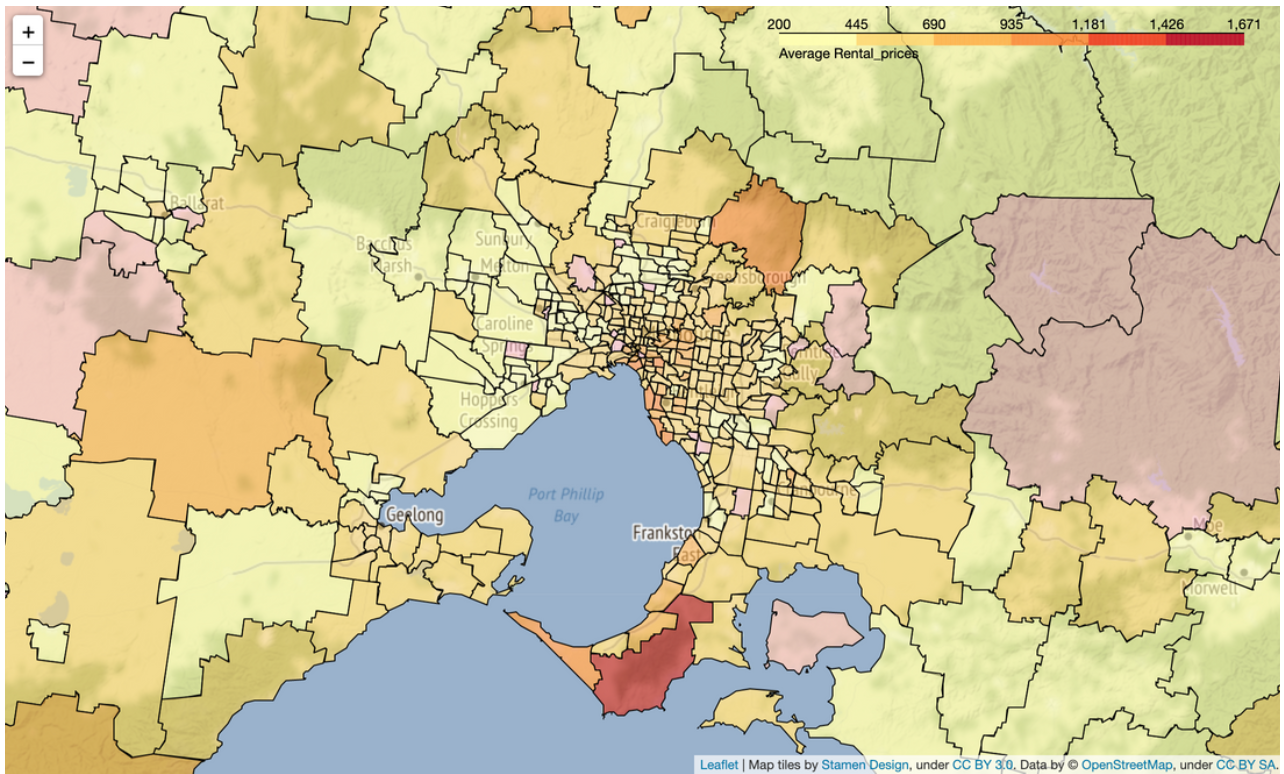

In [50]:
geo1 = Image.open('../plots/avg_rental_plot.png')
geo1

### Outlier Removal

1. From image 1, it can be detected that the distribution of rental price is significantly right-skewed. 

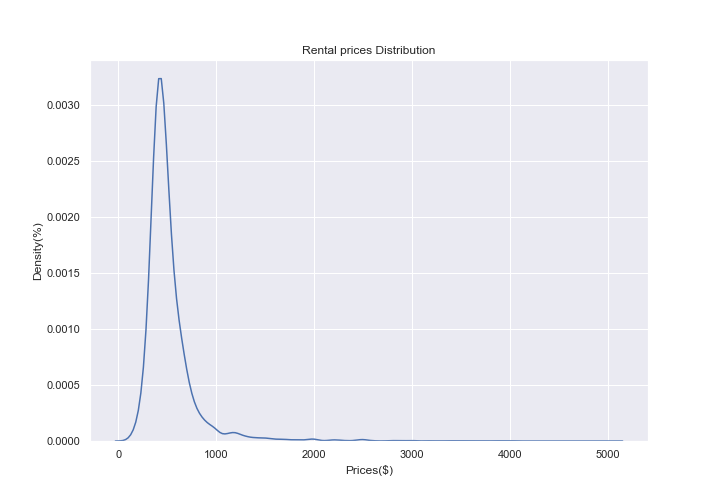

In [51]:
img1 = Image.open('../plots/rental_price_distrib_before.png')
img1

Hence we performed outlier removal by omitting the extreme rental price, namely rental price 1.5 times interquartile range larger than the 3rd quartile, or 1.5 times interquartile range smaller than the 1st quartile. Image 2 shows the distribution of rental prices after removing the outliers.

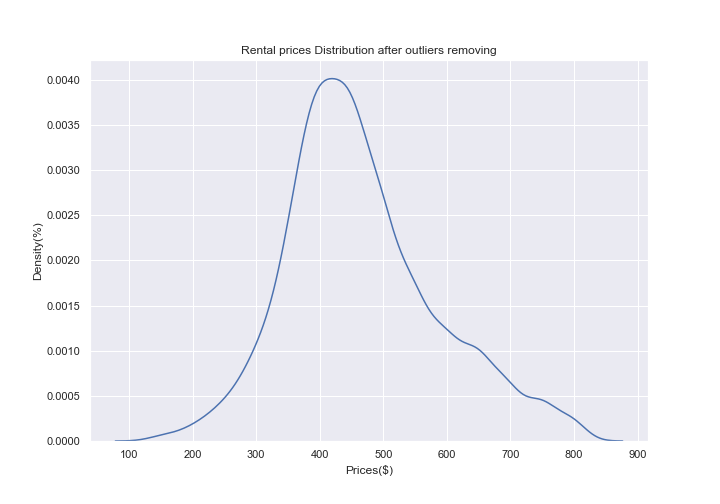

In [52]:
img2 = Image.open('../plots/rental_price_distrib_after.png')
img2

2. For the distance to CBD, we kept the outliers since we considered that it is necessary to take the properties in remote areas into account. Image 3 shows the distribution of distance to CBD.

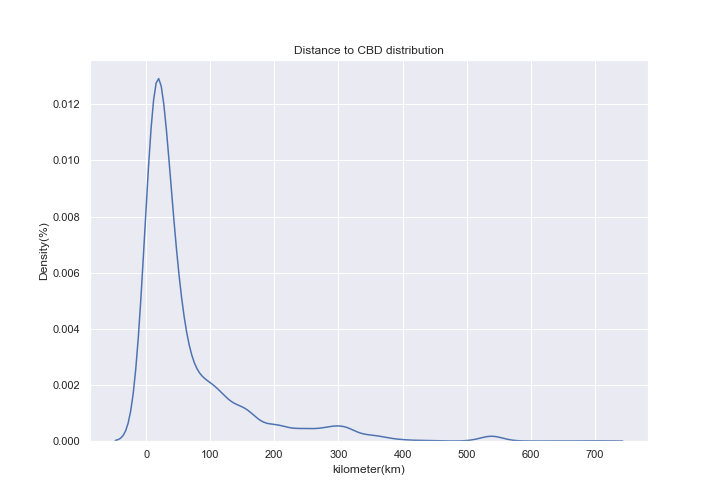

In [53]:
img3 = Image.open('../plots/distance_to_CBD_distrib.png')
img3

## 3. Assumptions

It is worth noticing that there are a few assumptions that we made in the research. 

1. We assumed there will be no significant change in the number of facilities such as schools and hospitals from 2022 to 2025. We did find the number of schools in 2019 and 2021 and by comparison, we found the change rate is small enough to prove our assumption. 

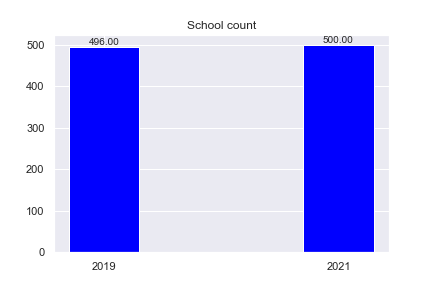

In [54]:
school_img = Image.open('../plots/school_change.png')

school_img

However, due to the lack of data of hospitals in 2019, 2012 data was found, we compared the number of hospotals in 2012 and 2021. There was a big increase within 9 years (total increasing rate 2.1857314148681053). However, when breaking down to 3 years, the increasing rate is minor.

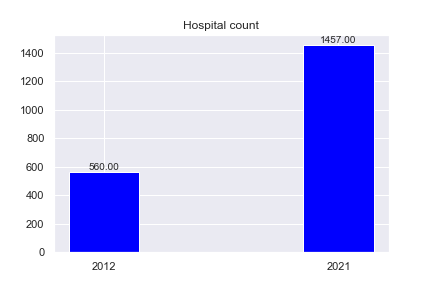

In [55]:
hos_img = Image.open('../plots/hos_change.png')

hos_img

Hence, it is reasonable to apply this to the future 3 years (2022-2025).

2. Secondly, the income data for 2022 based on SA2 district was not found. Hence we assume the income in 2022 can be predicted by using the average growth rate from 2014 to 2017.

3. Finally, since the granularity of data collection is SA2-based, for our purpose of this research, the external features is changed from per SA2 to per suburb by assuming the number of them in adjacent suburbs in one SA2 district is proportional to the number of properties in each suburb.

4. For missing values:
    1. we defult the properties have no car park if there is no car park information.
    2. we subsititute the mean suburb income and mean suburb population to those suburbs without those data.
    3. we directly remove the instances without price or location data.

##  4. Best Models

Various models including linear regression models and machine learning models have been trained in this research and the results are as follows:

In [56]:
##### Load our train-test dataframe and our prediction results #####

gpd_domain = pd.read_csv('../data/curated/df_model.csv')
X_train = pd.read_csv('../data/curated/X_train.csv')
y_train = pd.read_csv('../data/curated/y_train.csv')
X_test = pd.read_csv('../data/curated/X_valid.csv')
y_test = pd.read_csv('../data/curated/y_valid.csv')
X_pred = pd.read_csv('../data/curated/X_predict.csv')

X_train = X_train.drop(['Unnamed: 0', 'Unnamed: 0.1'],  axis = 1)
X_test = X_test.drop(['Unnamed: 0', 'Unnamed: 0.1'],  axis = 1)
X_pred = X_pred.drop(['Unnamed: 0', 'Unnamed: 0.1'],  axis = 1)
y_train = y_train.drop(['Unnamed: 0'],  axis = 1)
y_test = y_test.drop(['Unnamed: 0'],  axis = 1)

print('The shape of x train is', X_train.shape)
print('The shape of y train is', y_train.shape)
print('The shape of x valid is', X_test.shape)
print('The shape of y valid is', y_test.shape)
print('The shape of x prediction is', X_pred.shape)

The shape of x train is (3634, 13)
The shape of y train is (3634, 1)
The shape of x valid is (909, 13)
The shape of y valid is (909, 1)
The shape of x prediction is (4543, 13)


In [57]:
X_train['Income'] = X_train['Income2022']
X_train['popu'] = X_train['popu2022']
X_train = X_train.drop(['popu2022', 'Income2022'],  axis = 1)

X_test['Income'] = X_test['Income2022']
X_test['popu'] = X_test['popu2022']
X_test = X_test.drop(['popu2022', 'Income2022'],  axis = 1)

X_pred['Income'] = X_pred['Income2025']
X_pred['popu'] = X_pred['popu2025']
X_pred = X_pred.drop(['popu2025', 'Income2025'],  axis = 1)

1. Training data is as shown below

In [58]:
X_train.head()

Postcode  Bedrooms  Bathrooms  Parkings   SA2_code  Longitude    Latitude  \
0      3125         2          1         2  207031165 -37.848543  145.101833   
1      3175         1          1         1  212041563 -37.977222  145.209501   
2      3871         3          2         1  205031090 -38.405910  146.167173   
3      3219         3          1         3  203021045 -38.161770  144.397139   
4      3136         3          2         2  211031265 -37.767223  145.293041   

   hos_count  stop_count  school_count    distance        Income          popu  
0        0.0         0.0           5.0   15.130758  55919.413733  11933.426273  
1       27.0         1.0           8.0   33.513306  69737.528612  21825.525825  
2        1.0         0.0           3.0  155.051267  55805.973075   3291.393933  
3        4.0         0.0           5.0   82.960668  49553.343727  12529.116544  
4        0.0         0.0           7.0   36.121799  73988.790173  18194.157956

2. Prediction results and performance outcomes of our baseline model (simple linear regression), glm models and machine learning models are shown below.

In [59]:
model_perform = pd.read_csv('../data/curated/model.csv')
model_perform

Unnamed: 0                 model_name  prediction_score  \
0           0  GradientBoostingRegressor          0.660173   
1           2      RandomForestRegressor          0.634099   
2           1               XGBRegressor          0.654537   
3           6                        GLM               NaN   
4           3              Baselinemodel          0.419933   
5           4          AdaBoostRegressor          0.408678   
6           5                        ANN               NaN   

   mean_absolute_percentage_error  
0                        0.110329  
1                        0.112296  
2                        0.112425  
3                        0.145445  
4                        0.149277  
5                        0.173755  
6                        0.210000

3. We applied the top three models with lowest mean absolute percentage error to calculate the mean predicted price as the final result, first 5 line of prediction results is shown as below:

In [60]:
final_pred = pd.read_csv('../data/curated/prediction_result.csv')
final_pred.head()

Unnamed: 0  Postcode  2022_prices  2025_prices_XGB  \
0           0      3002        395.0        423.83298   
1           1      3002        750.0        678.98480   
2           2      3002        600.0        536.90814   
3           3      3002        380.0        445.48227   
4           4      3002        550.0        437.39430   

   2025_prices_RandomForest  2025_prices_GradientBoosting  
0                486.362761                    502.027265  
1                701.618145                    695.664636  
2                563.846369                    561.576131  
3                485.639153                    468.128123  
4                510.617997                    499.840732

## 5. Problem Solving 

The main purpose of this research is to resolve the following 3 questions:
* All predicted rental prices been used in question solving are the average predicted rental prices of the top 3 performed models as introduced in section 4.
* All the questions using suburb as granularity and hence our data been used is the average value taken after grouping by suburbs.

### Question1: What are the most important internal and external features in predicting rental prices?

By sorting the p-value of features in asending orders, we can see that three most important features are:
1. Income
2. Bedrooms
3. Bathrooms

Feature selection by p-value, s.t. removing the insignificant features with p-value>0.05.

In [61]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X_train)
#Fitting sm.OLS model
Feature_sel = sm.OLS(y_train,X_1).fit()
Feature_sel.pvalues.sort_values(ascending=True)

#Backward Elimination
cols = list(X_train.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
X_train = X_train[cols]
X_test = X_test[cols]

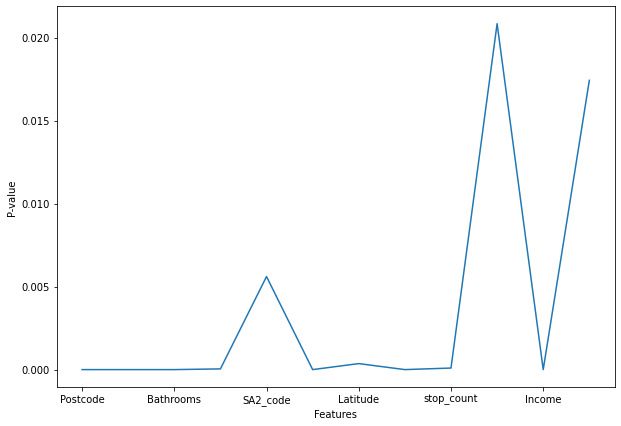

Income          2.757800e-120
Bedrooms         9.557031e-96
Bathrooms        3.091978e-86
hos_count        1.309427e-19
Postcode         2.217028e-12
Longitude        1.925254e-10
Parkings         4.185605e-05
stop_count       9.359499e-05
Latitude         3.610416e-04
SA2_code         5.606430e-03
popu             1.742740e-02
school_count     2.084349e-02
dtype: float64

In [62]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X_train)
#Fitting sm.OLS model
Feature_sel = sm.OLS(y_train,X_1).fit()
# remove const col
fea_importance = Feature_sel.pvalues[1:]


fig = plt.figure(figsize =(10, 7))
plt.xlabel("Features")
plt.ylabel("P-value")
fea_importance.plot()
plt.show()
fea_importance.sort_values(ascending=True)

### Question2: What are the top 10 suburbs with the highest predicted growth rate in rental prices?

To approach this question:
1. We first group the properties by suburbs (postcodes). 
2. Then for each suburb calculate the mean 2022 rental price and the mean (predicted) 2025 rental price.
3. Calculate and sort by the (predicted) average growth rate.

We then get the top 10 suburbs with the highest predicted growth rate as follows:

In [63]:
top10 = pd.read_csv('../data/curated/top10.csv')
top10

Unnamed: 0  Postcode  2022_prices  2025_price_mean  pred_growth_rate
0           0      3233   312.500000       402.420940          0.405138
1           1      3525   260.000000       325.995156          0.368137
2           2      3505   270.000000       350.248473          0.348311
3           3      3289   230.000000       306.367900          0.332034
4           4      3713   250.000000       332.919268          0.331677
5           5      3024   393.750000       518.612928          0.323353
6           6      3338   393.500000       518.419109          0.318821
7           7      3202   296.666667       386.539568          0.308608
8           8      3026   451.250000       585.206038          0.301611
9           9      3737   276.000000       330.656365          0.296418

Below is the plot filtering out the top 10 suburbs with the highest growth in terms of rental prices.

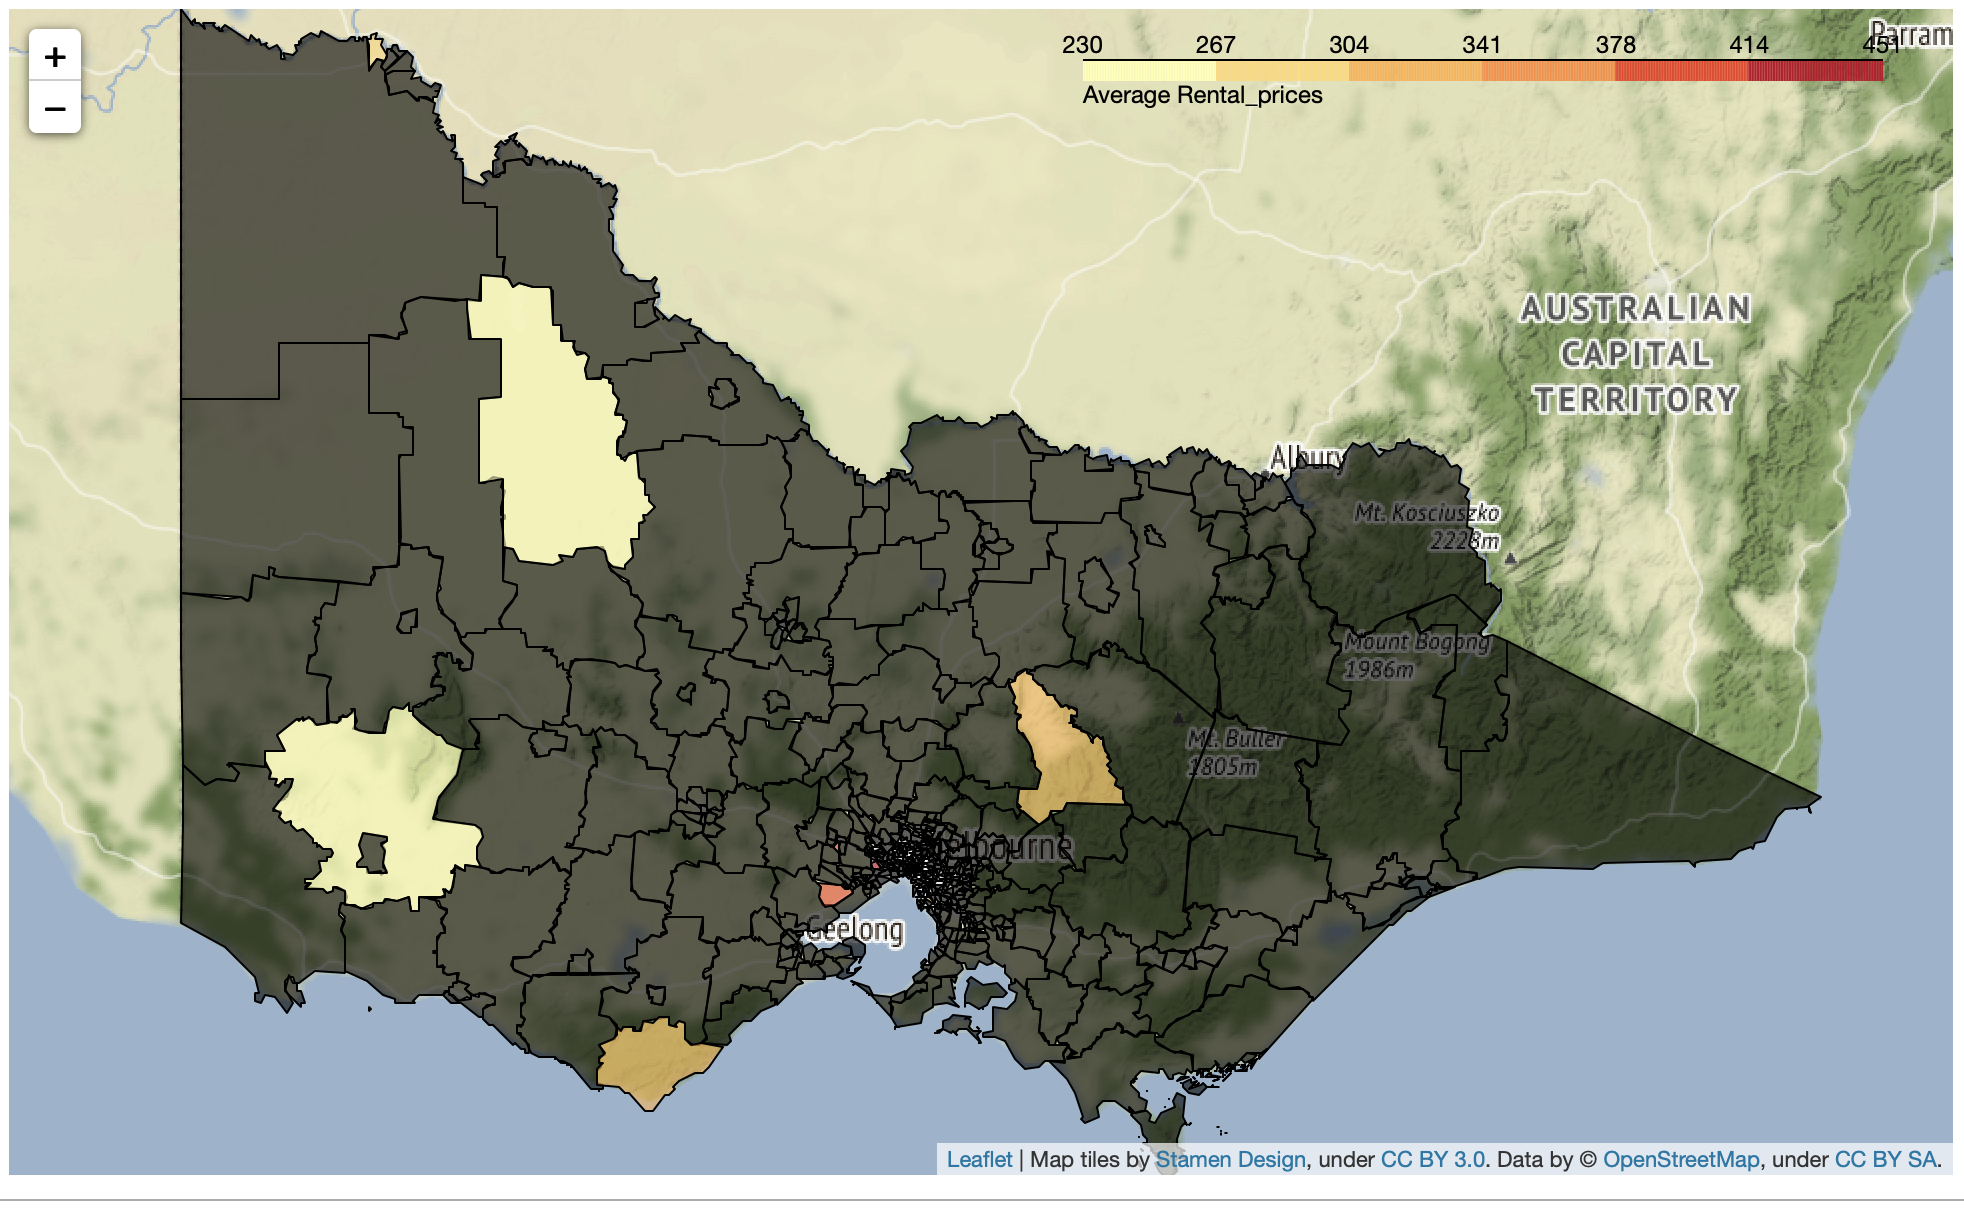

In [64]:
geo2 = Image.open('../plots/top10_1.png')
geo2

Zoom into the map we can see it reveals that 4 out of the top 10 gathered around the Melbourne Central region. 

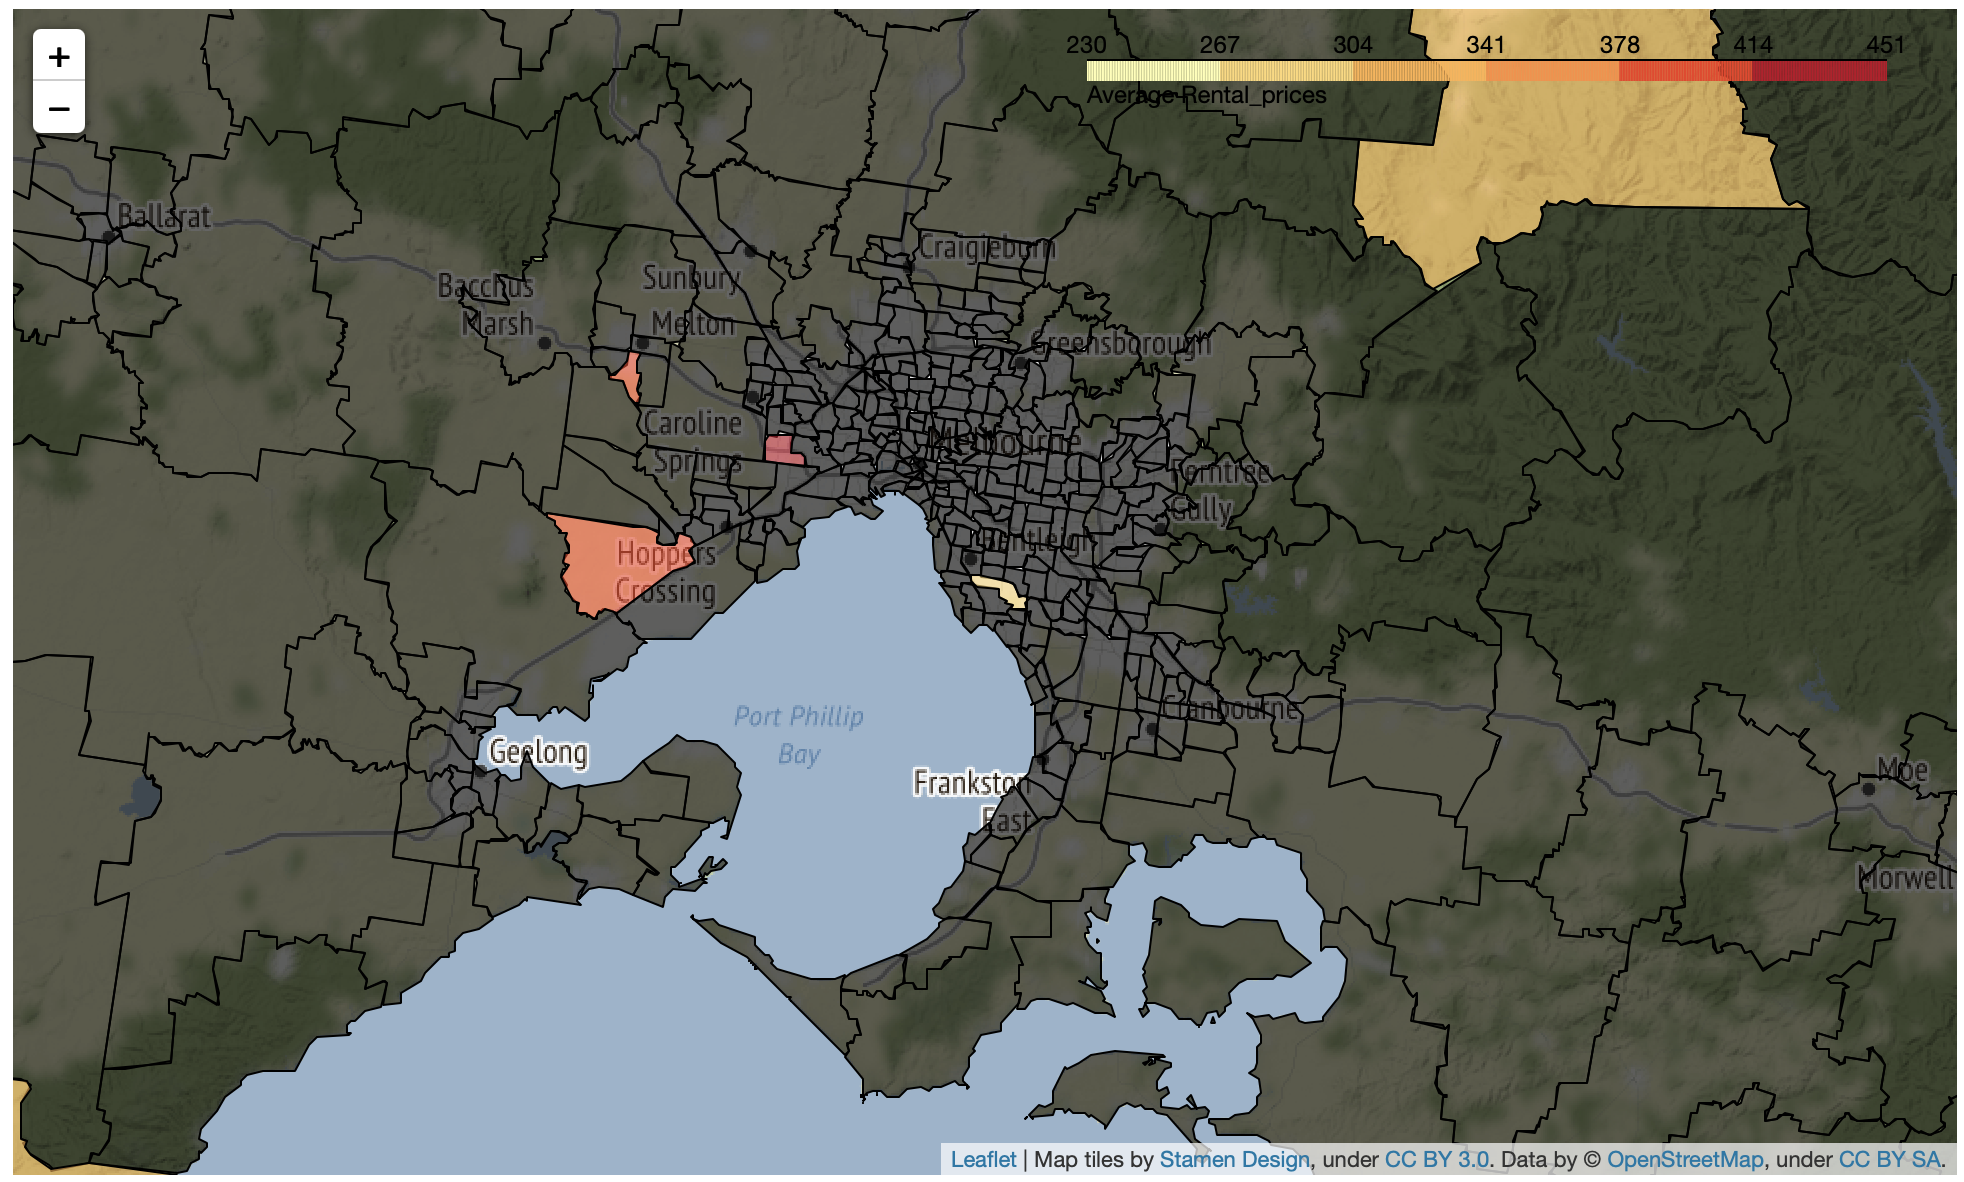

In [65]:
geo3 = Image.open('../plots/top10_2.png')
geo3

### Question3: What are the most liveable and affordable suburbs according to your chosen metrics?

1. In this research, we choose to define the affordability coefficients as follow:

 $$ 
  AffordabilityCoefficient = \frac{Annual Rental Price}{Annual Income} 
 $$

 and since our residents are more likely to prefer properties with lower affordability coefficient, that is, less proportion of annual rental price in their annual income, we perform:
 
  1. For each suburb, calculate the affordability coefficient based on predicted rental price and suburb average income.
  2. Sort in desending order.
  
 and we find the following suburbs:

In [66]:
df_aff = pd.read_csv('../data/curated/afford.csv')
df_aff['Postcode'].head(10)

0    3186
1    3142
2    3191
3    3143
4    3146
5    3193
6    3144
7    3206
8    3188
9    3126
Name: Postcode, dtype: int64

In [67]:
print('The most liveable suburb is', df_aff['Postcode'][0])

The most liveable suburb is 3186


2. In the data we collected, we believed that the features related to liveability includes number of schools, hospitals and public transportation, together with the population. We consider that people prefer suburbs with more number of schools, hospitals and public transport stations, as well as a lower population. Thus, we define the liveability coefficients as:
$$
 Liveability = \frac{SchoolCount + HospitalCount + StopCount}{Population}
$$

People prefer a property with higher liveability coefficient, hence we perform:
 
  1. For each suburb, calculate the liveability coefficient based on school_count, hospital_count, stop_count and predicted 2025 population 
  2. Sort in asending order.
  
 and we find the following suburbs:

In [68]:
df_liv = pd.read_csv('../data/curated/live.csv')
df_liv['Postcode'].head(10)

0    3239
1    3390
2    3393
3    3396
4    3302
5    3289
6    3700
7    3701
8    3707
9    3518
Name: Postcode, dtype: int64

In [69]:
print('The most liveable suburb is', df_liv['Postcode'][0])

The most liveable suburb is 3239


## 6. Limitations & Solutions

1. One of the most significant limitations in this research is the lack of time series tracking for time-varying attributes such as population and income. As stated in the assumption section, the income and population in 2025 is predicted according to data in 2022, by applying their average growth rate calculated based on data in previous years. However, this imposes a simple monotonic trend of growth to features that are clearly made up of rather complex changing patterns. This could significantly reduce the accuracy of our predicting outcomes since time-varying features play decisive roles in our model for prediction and hence incorrect tracking of their patterns could degrade the model dramatically. ARMA model is considered to fix this problem, however it requires quite long time series to meet the degree of freedom for prediction but data by SA2 usually do not cover such long time series.

2. Another limitation in this research is the simplified distance attribute. The attribute for distance in this project is calculated as the driving distance between the property and the Melbourne Central Station. This is not appropriate enough since nearby public transport stations around a property are ignored. As a result, distance has been removed from the attribute set and is not considered for final rental prediction.

3. In this research, some of the missing values are simply ignored, however we are not sure if they have some missing patterns included, which could result in a biased model. A better approach dealing with them is to apply mean imputation or Z-score imputation for more generalizes distribution.

4. It is worth noticing that around 4000 records are collected in this research, which could be a small data size considering using machine learning models as support for prediction. In order to meet an optimum data size, we might need to go deeper into each webpage during scrapping so that more records coud be extracted.
